**Todo:**

- Plot online and offline loss seperatly
- Add offline validdation
- Add MCF to both offline and online training (First without RS, if not work with RS) (RS = Reward Scheduling)
- Add linear rewards instead of booleans

In [1]:
# OpenPOM analysis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem

In [2]:
def explicit_H_filter(smiles: str) -> bool:
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        if atom.GetNumExplicitHs() > 1:
            return False  
    return True

In [3]:
df = pd.read_csv("openpomdata.csv").drop("descriptors",axis=1)
len(df)

4983

In [4]:

df =  df[df['odorless'] == False]
df = df[df["nonStereoSMILES"].apply(explicit_H_filter)].copy()  
df = df.reset_index(drop=True)
df.head()

,nonStereoSMILES,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,apricot,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
0,CC(O)CN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CCC(=O)C(=O)O,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,O=C(O)CCc1ccccc1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,OCc1ccc(O)cc1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,O=Cc1ccc(O)cc1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [5]:
len(df)

4782

In [6]:
vanilla_df = df[df['vanilla'] == True]
vanilla_df.head()

,nonStereoSMILES,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,apricot,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
4,O=Cc1ccc(O)cc1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
26,COc1ccccc1O,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
32,O=C1CCc2ccccc2O1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
62,COc1cc(C=O)ccc1O,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
65,COc1cc(C(C)=O)ccc1O,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [7]:
len(vanilla_df)

111

### Introduce MCF's

In [8]:
# MCF imports
from molecule_validation import is_odorant, score_molecule


############################################################
#                     Initialize MCFs                      #
############################################################

Filter                                        Min        Max
------------------------------------------------------------
LogP                                         0.06       4.91
Molecular Weight                           100.12     282.46
HBAB + HBD                                   0.00       5.00
TPSA                                         0.00      63.32
Rotatable Bonds                              0.00      11.00
NO2 Groups                                   0.00       0.00
Heteroatoms                                  0.00       4.00
Aromatic Rings                               0.00       1.00
Atom Count                                   0.00      20.00
Triple Bonds                                 0.00       0.00
Oxygen Chain Length                          0.00       1.00

#####################

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
def calculate_score(smiles, is_vanilla):
    mol = Chem.MolFromSmiles(smiles)
    # Odorant filter + All MCF Filters + Has vanilla scent / 3 (To calculate mean of these params)
    return (is_odorant(mol) + score_molecule(mol).all() + is_vanilla)/3

In [10]:
df['score'] = df.apply(lambda x: calculate_score(x.nonStereoSMILES, x.vanilla), axis=1)

In [11]:
sum([is_odorant(Chem.MolFromSmiles(s)) for s in df["nonStereoSMILES"]])

array([4735])

In [12]:
score_matrrix = np.array([score_molecule(Chem.MolFromSmiles(s)) for s in df["nonStereoSMILES"]])

In [13]:
(1000/443)*120

270.8803611738149

In [14]:
score_matrrix

array([[0, 0, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 1, 1]])

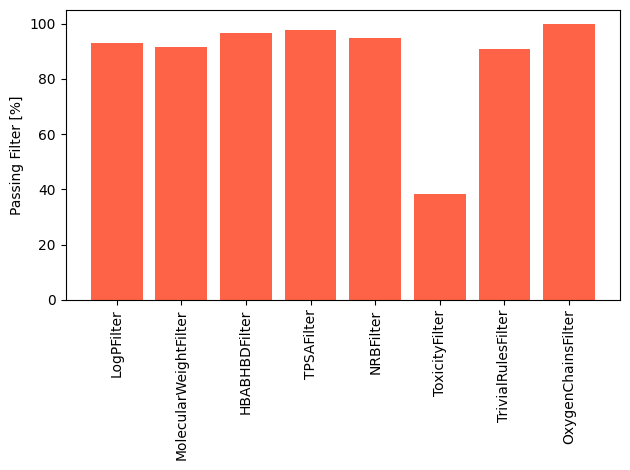

In [15]:
# Count number of failures (False) per filter (i.e., column-wise)
fail_counts = np.sum(score_matrrix, axis=0)/len(df)*100
filter_names = ["LogPFilter","MolecularWeightFilter","HBABHBDFilter","TPSAFilter","NRBFilter","ToxicityFilter","TrivialRulesFilter","OxygenChainsFilter"]


plt.bar(filter_names, fail_counts, color='tomato')
plt.ylabel('Passing Filter [%]')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
fail_counts/len(df)

array([0.01942055, 0.01914068, 0.0202077 , 0.02040448, 0.01979663,
       0.00802885, 0.01900512, 0.02090738])

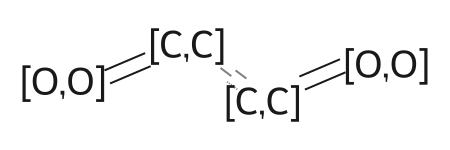

In [17]:
toxic_smarts = [
        "[N+](=O)[O-]",  # Nitro groups
        "[#6](=O)[#8]",  # Carboxylic acid
        "[F,Cl,Br,I][C,c]=[C,c]",  # Halogen-substituted electrophiles
        "[S,s]~[S,s]",  # Disulfides
        "[C;R][C;R]",  # Strained rings
        "[N,n][O,o]",  # Hydroxamic acids
        "[N,n]~[N,n]",  # Diazo compounds
        "[C,c](=[O,o])[C,c](=[O,o])",  # Anhydrides
    ]
toxic_patterns = [Chem.MolFromSmarts(smarts) for smarts in toxic_smarts]

toxic_patterns[7]

In [18]:
len(df[df["score"]==0]), len(df)

(44, 4782)

In [19]:
len(df[df["score"]==0]),len(df[df["score"]==1/3]),len(df[df["score"]==2/3]),len(df[df["score"]==1])

(44, 4628, 110, 0)

In [20]:
import torch

In [21]:
(torch.tensor([0.1,0.3,0.7]).float() +torch.tensor([1/3, 0,2/3]))/3

tensor([0.1444, 0.1000, 0.4556])

In [ ]:
#trajectory balance line 452 
# Custom Code: Ensures that unprobabile actions dont get -inf as a Pf (Paul)
#log_p_F = log_p_F.clamp(-100)

SyntaxError: invalid syntax (1941753126.py, line 1)

In [23]:
np.exp(-69)

1.0806392777072785e-30

In [24]:
np.log(1e-30)

-69.07755278982137

In [25]:
torch.tensor([0.1,0.3,0.7]).float().size()

torch.Size([3])

In [26]:
(torch.tensor([0.1,0.3,0.7]).float()+torch.tensor([0.1,0.3,0.7])) /3

tensor([0.0667, 0.2000, 0.4667])

In [27]:
def calculate_score_online(mol):
    # Odorant filter + All MCF Filters + Has vanilla scent / 3 (To calculate mean of these params)
    return is_odorant(mol) + score_molecule(mol).all()

In [28]:
calculate_score_online(Chem.MolFromSmiles("CCC"))[0]

False

In [29]:
score_molecule(Chem.MolFromSmiles("CCC")).all()

False

In [30]:
is_odorant(Chem.MolFromSmiles("CCC"))

array([False])

In [31]:
from pom_models.functions import fragance_propabilities_from_smiles

from numpy.linalg import norm

TARGET_SMILES = "COC1=C(C=CC(=C1)C=O)O"
TARGET_VEC = fragance_propabilities_from_smiles(TARGET_SMILES)[0]

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [35]:


def cosine_similarity(vec1,vec2):
    return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))

def compute_reward_from_mols(mols):
    rewards = []
    m_vecs = []
    for m in mols:
        m_vec = fragance_propabilities_from_smiles(m)[0]
        rewards.append(cosine_similarity(TARGET_VEC,m_vec))
        m_vecs.append(m_vec)
    return rewards, m_vecs
    


In [36]:
df["OpenPOM"],mvecs = compute_reward_from_mols(df["nonStereoSMILES"])

In [37]:
mvecs

[array([0.05368503, 0.02222416, 0.15147005, 0.09308437, 0.01436115,
        0.0902456 , 0.05017666, 0.0175485 , 0.02621217, 0.09404659,
        0.08330674, 0.01747935, 0.13010655, 0.01465969, 0.0776481 ,
        0.14597575, 0.07502115, 0.02883432, 0.20773005, 0.13616168,
        0.10985476, 0.0485954 , 0.24721718, 0.01055312, 0.04373205,
        0.02043754, 0.17680964, 0.05848923, 0.10773856, 0.02012257,
        0.04042768, 0.0723649 , 0.04529578, 0.08590453, 0.07306283,
        0.17874926, 0.01861137, 0.14001667, 0.08359893, 0.02897091,
        0.04971445, 0.21033528, 0.0060349 , 0.14890599, 0.10409953,
        0.1147588 , 0.06541213, 0.1554045 , 0.07329743, 0.15149459,
        0.07398289, 0.08120436, 0.0641885 , 0.2035872 , 0.16103579,
        0.0776257 , 0.01751022, 0.08611301, 0.03970468, 0.04952769,
        0.10432926, 0.03675972, 0.06188544, 0.09112291, 0.08732539,
        0.03025301, 0.01125487, 0.03675674, 0.02839591, 0.03586514,
        0.03471653, 0.01237459, 0.01939965, 0.03

In [42]:
mvecs3 = np.array(mvecs)

In [39]:
df.keys()[1:-2]

Index(['alcoholic', 'aldehydic', 'alliaceous', 'almond', 'amber', 'animal',
       'anisic', 'apple', 'apricot', 'aromatic',
       ...
       'tropical', 'vanilla', 'vegetable', 'vetiver', 'violet', 'warm', 'waxy',
       'weedy', 'winey', 'woody'],
      dtype='object', length=138)

In [43]:

data = {df.keys()[0]: df["nonStereoSMILES"]}  # first column


for idx, col in enumerate(df.keys()[1:-2]):
    data[col] = mvecs3[:, idx]
openpom_vals_df = pd.DataFrame(data)

In [45]:
openpom_vals_df.to_csv("OpenPOM_probs.csv",index=False)

In [47]:
openpom_vals_df.sort_values("vanilla").tail()

,nonStereoSMILES,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,apricot,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
65,COc1cc(C(C)=O)ccc1O,0.047840,0.047906,0.053694,0.278616,0.042075,0.224340,0.372801,0.025996,0.049247,...,0.113842,0.661039,0.057080,0.075971,0.030697,0.254491,0.072785,0.030222,0.114572,0.439656
2279,COc1ccc(C=O)cc1O,0.045805,0.042781,0.052986,0.286663,0.032905,0.202872,0.363611,0.021178,0.042379,...,0.100146,0.661828,0.048737,0.070083,0.024058,0.237194,0.060920,0.024577,0.119334,0.437746
392,COc1cc(C=O)cc(OC)c1O,0.043539,0.037861,0.052310,0.234962,0.031796,0.198427,0.352592,0.017998,0.039751,...,0.087414,0.663249,0.048042,0.066468,0.022202,0.225463,0.061112,0.020381,0.107162,0.438074
386,CCOc1cc(C=O)ccc1O,0.055721,0.048777,0.058255,0.273882,0.043234,0.217613,0.371482,0.029088,0.052148,...,0.117842,0.665118,0.060351,0.074881,0.029365,0.232532,0.072567,0.031594,0.133990,0.420452
4532,CC(C)Oc1cc(C=O)ccc1O,0.067121,0.062927,0.063773,0.284094,0.053838,0.231481,0.359625,0.039849,0.060905,...,0.139409,0.667435,0.073669,0.083416,0.035401,0.253007,0.084238,0.039747,0.140019,0.414526


In [48]:
df[df["vanilla"]==1].tail(5)

,nonStereoSMILES,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,apricot,...,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody,score,OpenPOM
4482,O=C1Oc2ccccc2C2CC12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,[0.6666666666666666],0.918295
4532,CC(C)Oc1cc(C=O)ccc1O,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,[0.6666666666666666],0.991079
4675,C=CCc1ccc(OCCC(C)C)c(OC)c1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,[0.6666666666666666],0.956425
4706,COc1cc(C2OC(C)C(C)O2)ccc1O,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,[0.6666666666666666],0.987876
4757,CCOC1OC(CO)C(O)C(O)C1O.COc1cc(C=O)ccc1O,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,[0.6666666666666666],0.936418


In [57]:
df2 = pd.read_csv("openpomdata.csv")

In [58]:
df2[df2["nonStereoSMILES"]=="COC1=C(C=CC(=C1)C=O)O"]

,nonStereoSMILES,descriptors,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody


In [50]:
df[df["nonStereoSMILES"]=="COC1=C(C=CC(=C1)C=O)O"]

,nonStereoSMILES,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,apricot,...,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody,score,OpenPOM


In [59]:
openpom_vals_df

,nonStereoSMILES,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,apricot,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
0,CC(O)CN,0.053685,0.022224,0.151470,0.093084,0.014361,0.090246,0.050177,0.017548,0.026212,...,0.105321,0.129228,0.130414,0.040546,0.009187,0.061104,0.025321,0.018047,0.092431,0.141428
1,CCC(=O)C(=O)O,0.071581,0.080258,0.097939,0.164063,0.078892,0.158250,0.125030,0.111781,0.126909,...,0.330327,0.209101,0.168391,0.082237,0.066885,0.137452,0.150863,0.106753,0.384470,0.176524
2,O=C(O)CCc1ccccc1,0.114936,0.104388,0.077720,0.308967,0.138070,0.270737,0.263540,0.115183,0.168432,...,0.235040,0.297464,0.112444,0.126946,0.079700,0.185000,0.226909,0.139591,0.260700,0.237712
3,OCc1ccc(O)cc1,0.059922,0.036736,0.093877,0.265072,0.036693,0.216537,0.292059,0.015693,0.047896,...,0.077390,0.570105,0.062639,0.067609,0.020459,0.158936,0.073606,0.023613,0.128608,0.384037
4,O=Cc1ccc(O)cc1,0.060794,0.056841,0.065455,0.411713,0.042579,0.223557,0.340441,0.034377,0.060797,...,0.127307,0.597516,0.059785,0.089438,0.032365,0.248587,0.070162,0.040805,0.170402,0.408618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4777,C=C(C=CO)CCC=C(C)CCC=C(C)C,0.071503,0.449908,0.071471,0.091108,0.143873,0.150710,0.133683,0.198195,0.159938,...,0.382499,0.084091,0.207167,0.138997,0.293346,0.211949,0.423315,0.232668,0.098696,0.365851
4778,CCC(C)C1=NC(C)C(CC)S1,0.050348,0.044220,0.328271,0.171364,0.045596,0.150540,0.087809,0.030943,0.047673,...,0.167446,0.087337,0.396026,0.058563,0.025630,0.049550,0.049736,0.041507,0.052698,0.223731
4779,CCC1SC(CC(C)C)=NC1C,0.055375,0.048549,0.327511,0.181485,0.049704,0.154787,0.089940,0.034842,0.052877,...,0.185850,0.092613,0.404577,0.062128,0.029011,0.051576,0.054196,0.045520,0.054498,0.230311
4780,CCC1SC(C)=NC(C)S1,0.022803,0.023087,0.391915,0.106160,0.026086,0.117231,0.062736,0.015930,0.025524,...,0.105732,0.038968,0.380348,0.032693,0.012949,0.028762,0.038936,0.024576,0.029300,0.141131


In [53]:
list(openpom_vals_df["nonStereoSMILES"].str.strip()).index("COC1=C(C=CC(=C1)C=O)O")

ValueError: 'COC1=C(C=CC(=C1)C=O)O' is not in list

In [55]:
"COC1=C(C=CC(=C1)C=O)O"=="COC1=C(C=CC(=C1)C=O)O"

True

In [54]:
openpom_vals_df["nonStereoSMILES"]

0                             CC(O)CN
1                       CCC(=O)C(=O)O
2                    O=C(O)CCc1ccccc1
3                       OCc1ccc(O)cc1
4                      O=Cc1ccc(O)cc1
                    ...              
4777       C=C(C=CO)CCC=C(C)CCC=C(C)C
4778            CCC(C)C1=NC(C)C(CC)S1
4779              CCC1SC(CC(C)C)=NC1C
4780                CCC1SC(C)=NC(C)S1
4781    CC1CCC(C(C)C)C(OCC(C)(O)CO)C1
Name: nonStereoSMILES, Length: 4782, dtype: object

In [49]:
openpom_vals_df[openpom_vals_df["nonStereoSMILES"]=="COC1=C(C=CC(=C1)C=O)O"]

,nonStereoSMILES,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,apricot,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

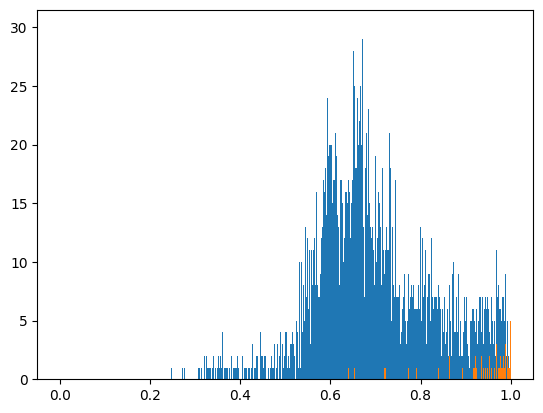

In [49]:
#df["OpenPOM"].hist(bins=100)
#df[df["vanilla"]==1]["OpenPOM"].hist(bins=100)
bins= 1000
plt.hist(df["OpenPOM"], bins=np.linspace(0,1,bins))
plt.hist(df[df["vanilla"]==1]["OpenPOM"], bins=np.linspace(0,1,bins))

<Axes: >

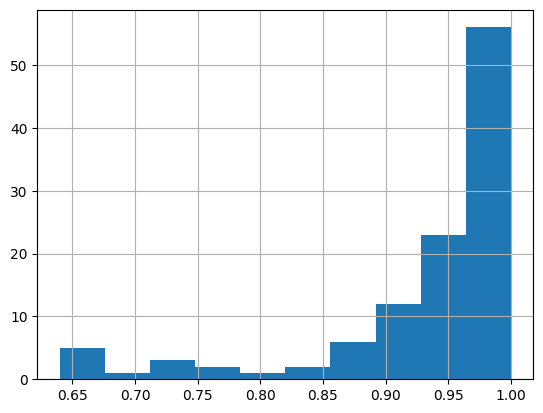

In [42]:
df[df["vanilla"]==1]["OpenPOM"].hist(bins=10)